In [592]:
# from darts import TimeSeries
import pandas as pd
from darts.models import NaiveSeasonal
from darts.models import NaiveMean
from darts import TimeSeries
from sklearn.metrics import mean_absolute_percentage_error
from typing import Dict


In [2]:
# df = pd.read_excel('../../data/raw/Количество исследований по неделям (для реализации).xlsx')
# df = df.rename(columns={"Год": "year", "Номер недели": "week"})
# df.fillna(0, inplace=True)
# ds_index = pd.date_range("2021-12-24", "2024-1-28", freq="W", name="ds").to_frame().reset_index(drop=True)
# ds_index["year"] = ds_index["ds"].dt.year
# ds_index["week"] = ds_index["ds"].dt.isocalendar().week
# ds_index['week'][0] = 52
# ds_index['week'][1] = 1
# ds_index['week'][2:54] += 1
# data = ds_index.merge(df, how="left", on=["year", "week"])
# data.fillna(0, inplace=True)
# series = TimeSeries.from_dataframe(
#     data,
#     time_col='ds',
#     value_cols=[column for column in df.columns if column not in ['year', 'week']]
# )

In [7]:
df = pd.read_parquet("../../data/processed/dataset.parquet")
df.head(5)

,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф,ds,feat_КТ с КУ 1 зона_lag-4_КТ,feat_КТ_lag-1_КТ с КУ 1 зона,feat_МРТ_lag-6_КТ с КУ 2 и более зон,feat_МРТ с КУ 1 зона_lag-1_МРТ,feat_МРТ_lag-1_МРТ с КУ 1 зона,feat_КТ с КУ 1 зона_lag-1_ММГ
1,17.0,6146,43.0,100.0,483,415,169.0,2.0,12450,392.0,2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2,1026.0,10868,424.0,451.0,9567,2156,669.0,9.0,48904,22626.0,2022-01-10,NaN,43.0,NaN,415.0,169.0,483.0
3,910.0,12266,430.0,490.0,8791,2162,710.0,14.0,47364,20496.0,2022-01-17,NaN,424.0,NaN,2156.0,669.0,9567.0
4,679.0,12793,336.0,471.0,7465,2066,667.0,7.0,40234,15227.0,2022-01-24,NaN,430.0,NaN,2162.0,710.0,8791.0
5,571.0,13235,302.0,446.0,6124,1900,609.0,6.0,36502,12586.0,2022-01-31,6146.0,336.0,NaN,2066.0,667.0,7465.0


In [670]:
df_features_0 = pd.read_excel("../../data/raw/Data_set_usl.xlsx", sheet_name=0)
df_features_1 = pd.read_excel("../../data/raw/Data_set_usl.xlsx", sheet_name=1)

In [668]:
df_features_0["ds"] = pd.to_datetime(df_features_0['year'].astype('str') + '-' + df_features_0['week'].astype('str') + '-1', format="%Y-%W-%w")
df_features_1["ds"] = pd.to_datetime(df_features_1['year'].astype('str') + '-' + df_features_1['week'].astype('str') + '-1', format="%Y-%W-%w")
df_features_0.set_index("ds", inplace=True)
df_features_1.set_index("ds", inplace=True)
df_features = df_features_0.join(df_features_1["scount"].rename(columns={"scount": "rg"}))

,scount,year,month,week,ds
0,187,2022,1,1,2022-01-03
1,277,2022,1,2,2022-01-10
2,267,2022,1,3,2022-01-17
3,289,2022,1,4,2022-01-24
4,41,2022,1,5,2022-01-31
...,...,...,...,...,...
146,227,2024,5,18,2024-04-29
147,344,2024,5,19,2024-05-06
148,351,2024,5,20,2024-05-13
149,347,2024,5,21,2024-05-20


In [251]:
series = TimeSeries.from_dataframe(
    df,
    time_col='ds',
    value_cols=[column for column in df.columns if column not in ['ds'] and 'feat' not in column]
)

In [634]:
def cross_val(
        models: Dict[str, object],
        series: TimeSeries,
        remains_rows_to_val: int = 24,
        n_rows_to_forecast: int = 4,
        step: int = 1,
) -> Dict[str, Dict[str, pd.Series]]:
    """
    Perform cross-validation on a given set of models and a time series.

    Args:
        models (Dict[str, object]): A dictionary of models to be used for cross-validation.
        series (TimeSeries): The time series data to be used for cross-validation.
        remains_rows_to_val (int, optional): The number of rows to be used for validation. Defaults to 24.
        n_rows_to_forecast (int, optional): The number of rows to be forecasted. Defaults to 4.
        step (int, optional): The step size for iterating over the training data. Defaults to 1.

    Returns:
        Dict[str, Dict[str, pd.Series]]: A dictionary containing the cross-validation results for each combination of training and forecasting
        rows. The keys are strings representing the combination of rows, and the values are dictionaries containing
        the MAPE (mean absolute percentage error) for each model by each column.
      Example: []
    """
    remains_rows_to_val = 24
    n_rows_to_forecast = 4
    step = 1
    if remains_rows_to_val < n_rows_to_forecast:
        raise ValueError("remains_rows_to_val count must be higher then n_rows_to_forecast")

    cross_val_results = {}
    predicts_list = []
    for n_rows_to_train in range(len(series) - remains_rows_to_val, len(series) - n_rows_to_forecast + 1, step):
        print(f"n_rows_to_train: {n_rows_to_train}", f"n_rows_for_forecast: {n_rows_to_train + n_rows_to_forecast}")
        train = series[:n_rows_to_train]
        val = series[n_rows_to_train:n_rows_to_train + n_rows_to_forecast]
        
        # Future covariates
        
        df_holidays = pd.DataFrame(series.time_index.strftime("%W") == "01", columns=["holidays"])
        df_holidays["ds"] = series.time_index
        # holidays_series = TimeSeries.from_dataframe(
        #     df_holidays,
        #     time_col='ds',
        #     value_cols=["holidays"]
        # )

        iteration_results = {}
        
        # add predictions to output
        
        
        for name, model in models.items():
            # Model based on diff
            
            # Drop first week in train
            train_current_no_week = train.pd_dataframe().copy()
            train_current_no_week[train_current_no_week.index.strftime("%W") == "01"] = None
            train_current_no_week = train_current_no_week.fillna(method="ffill")
                        
            train_current_no_week_series = TimeSeries.from_dataframe(
                train_current_no_week.dropna(),
                value_cols=[column for column in train_current_no_week.columns if column not in ['ds']],
                freq="W-MON",
                fill_missing_dates=True,
            )
            
            model.fit(train_current_no_week_series) #train.diff() , future_covariates=holidays_series
            preds = model.predict(n_rows_to_forecast) # , future_covariates=holidays_series
            df_pred = pd.DataFrame(preds.values(), columns=train.columns) #preds.cumsum().values() + train.values()[-1, :]
            df_pred["ds"] = val.pd_dataframe().index
            df_pred['model_name'] = name
            df_pred['n_rows_to_train'] = n_rows_to_train
            df_pred['week_num_prediction'] = df_pred['n_rows_to_train'] + df_pred.index + 1
            
            df_shifted_values = series.pd_dataframe().copy()
            columns_to_shift = df_shifted_values.columns
            df_shifted_values[columns_to_shift] = df_shifted_values[columns_to_shift].shift(52)
            df_pred.set_index("ds", inplace=True)
            # df_shifted_values.set_index("ds", inplace=True)
            df_pred.loc[df_pred.index.strftime("%W") == "01", columns_to_shift] = df_shifted_values
            predicts_list.append(df_pred)
            pred_series = TimeSeries.from_dataframe(
                df_pred,
                # time_col='ds',
                value_cols=[column for column in df.columns if column not in ['ds'] and 'feat' not in column]
            )
            iteration_results[name] = calc_mape_for_each_column(val, pred_series)

        cross_val_results[f'{n_rows_to_train} + {n_rows_to_forecast}'] = iteration_results

    return cross_val_results, pd.concat(predicts_list)


def represent_cross_validation_results(
    models: Dict[str, object],
    cross_val_results: Dict[str, Dict[str, pd.Series]]
) -> None:
    """
    Represent the cross-validation results for each model.

    Args:
        models (Dict[str, object]): A dictionary of models.
        cross_val_results (Dict[str, Dict[str, float]]): A dictionary containing the cross-validation results for each combination of training and forecasting rows.

    Returns:
        None
    """
    for model in models:
        represent_model_dict = {}
        for validation_step in cross_val_results:
            represent_model_dict[validation_step] = cross_val_results[validation_step][model]

        represent_model_df = pd.DataFrame(represent_model_dict).T  # transpose DataFrame
        model_df_with_stats = pd.concat([represent_model_df, represent_model_df.describe()])

        display(model_df_with_stats.style.set_caption(f'{model}'))

    return


def calc_mape_for_each_column(
        val: TimeSeries, 
        preds: TimeSeries,
) -> pd.Series:
    """
    Calculate the Mean Absolute Percentage Error (MAPE) for each column between the actual values (val) and predicted values (preds).

    Args:
        val (TimeSeries): The actual values TimeSeries.
        preds (TimeSeries): The predicted values TimeSeries.

    Returns:
        pd.Series: A Series containing the MAPE for each column.
    """
    mape_dict = {}
    for column in preds.columns:
        mape_dict[column] = mean_absolute_percentage_error(val[column].values(), preds[column].values())

    # mape_series = pd.Series(mape_dict)
    # mape_stats: pd.Series = mape_series.describe()
    # mape_and_mape_stats = pd.concat([mape_series, mape_stats])

    return pd.Series(mape_dict)


models = {
    'Naive_mean': NaiveMean() , 
    'Naive_seasonal_K52': NaiveSeasonal(K=52), 
}
ress, predictions = cross_val(models, series)
represent_cross_validation_results(models, ress)



n_rows_to_train: 84 n_rows_for_forecast: 88
n_rows_to_train: 85 n_rows_for_forecast: 89
n_rows_to_train: 86 n_rows_for_forecast: 90


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 87 n_rows_for_forecast: 91
n_rows_to_train: 88 n_rows_for_forecast: 92
n_rows_to_train: 89 n_rows_for_forecast: 93


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 90 n_rows_for_forecast: 94
n_rows_to_train: 91 n_rows_for_forecast: 95
n_rows_to_train: 92 n_rows_for_forecast: 96


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 93 n_rows_for_forecast: 97
n_rows_to_train: 94 n_rows_for_forecast: 98
n_rows_to_train: 95 n_rows_for_forecast: 99


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 96 n_rows_for_forecast: 100
n_rows_to_train: 97 n_rows_for_forecast: 101
n_rows_to_train: 98 n_rows_for_forecast: 102


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 99 n_rows_for_forecast: 103
n_rows_to_train: 100 n_rows_for_forecast: 104


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")


n_rows_to_train: 101 n_rows_for_forecast: 105
n_rows_to_train: 102 n_rows_for_forecast: 106
n_rows_to_train: 103 n_rows_for_forecast: 107


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/tmp/ipykern

n_rows_to_train: 104 n_rows_for_forecast: 108


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.123962,0.522608,0.148842,0.050066,0.180985,0.181530,0.056057,0.477575,0.142713,0.244346
85 + 4,0.129042,0.416583,0.109022,0.061739,0.192264,0.193707,0.041751,0.374550,0.176284,0.243383
86 + 4,0.124578,0.280735,0.101551,0.085162,0.151446,0.185160,0.051537,0.372428,0.155438,0.349244
87 + 4,0.143368,0.205484,0.071531,0.120678,0.159848,0.163278,0.040952,0.302823,0.183311,0.359472
88 + 4,0.162163,0.146825,0.085784,0.158832,0.183027,0.143305,0.054577,0.261200,0.207429,0.365132
89 + 4,0.193345,0.092193,0.105216,0.211461,0.201831,0.116355,0.070880,0.369829,0.220400,0.380301
90 + 4,0.234426,0.067834,0.129813,0.231950,0.267473,0.111049,0.077184,0.353855,0.287881,0.263371
91 + 4,0.253454,0.039563,0.159691,0.266808,0.282356,0.120118,0.108417,0.430046,0.298408,0.262722
92 + 4,0.271908,0.028780,0.172230,0.282102,0.292526,0.125041,0.118907,0.521729,0.301264,0.259359
93 + 4,0.292095,0.029040,0.127446,0.262637,0.280470,0.134496,0.107280,0.553467,0.293296,0.298547


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.340149,0.228405,0.113406,0.225882,0.255791,0.054850,0.064273,0.542424,0.268210,0.132958
85 + 4,0.333061,0.204933,0.100873,0.254547,0.261242,0.084699,0.065749,0.573674,0.285237,0.123887
86 + 4,0.275116,0.126175,0.095266,0.279949,0.197236,0.096964,0.069949,0.625145,0.251292,0.236366
87 + 4,0.269600,0.094666,0.103460,0.278980,0.209205,0.088836,0.085248,0.541811,0.260254,0.250671
88 + 4,0.244786,0.055882,0.091745,0.296891,0.213853,0.090636,0.108863,0.521609,0.251670,0.281241
89 + 4,0.264619,0.038251,0.150206,0.321669,0.213366,0.070191,0.129921,0.498693,0.233569,0.335626
90 + 4,0.345944,0.045802,0.198828,0.306314,0.279212,0.049270,0.132733,0.462847,0.277737,0.231837
91 + 4,0.338121,0.059805,0.196224,0.313228,0.263660,0.061147,0.137154,0.559906,0.278329,0.266600
92 + 4,0.398070,0.091369,0.226086,0.342150,0.291288,0.085274,0.141377,0.561642,0.308613,0.256944
93 + 4,0.401951,0.083046,0.190613,0.305670,0.263541,0.089250,0.108845,0.583071,0.300278,0.356058


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.123962,0.522608,0.148842,0.050066,0.180985,0.181530,0.056057,0.477575,0.142713,0.244346
85 + 4,0.129042,0.416583,0.109022,0.061739,0.192264,0.193707,0.041751,0.374550,0.176284,0.243383
86 + 4,0.124578,0.280735,0.101551,0.085162,0.151446,0.185160,0.051537,0.372428,0.155438,0.349244
87 + 4,0.143368,0.205484,0.071531,0.120678,0.159848,0.163278,0.040952,0.302823,0.183311,0.359472
88 + 4,0.162163,0.146825,0.085784,0.158832,0.183027,0.143305,0.054577,0.261200,0.207429,0.365132
89 + 4,0.193345,0.092193,0.105216,0.211461,0.201831,0.116355,0.070880,0.369829,0.220400,0.380301
90 + 4,0.234426,0.067834,0.129813,0.231950,0.267473,0.111049,0.077184,0.353855,0.287881,0.263371
91 + 4,0.253454,0.039563,0.159691,0.266808,0.282356,0.120118,0.108417,0.430046,0.298408,0.262722
92 + 4,0.271908,0.028780,0.172230,0.282102,0.292526,0.125041,0.118907,0.521729,0.301264,0.259359
93 + 4,0.292095,0.029040,0.127446,0.262637,0.280470,0.134496,0.107280,0.553467,0.293296,0.298547


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.340149,0.228405,0.113406,0.225882,0.255791,0.054850,0.064273,0.542424,0.268210,0.132958
85 + 4,0.333061,0.204933,0.100873,0.254547,0.261242,0.084699,0.065749,0.573674,0.285237,0.123887
86 + 4,0.275116,0.126175,0.095266,0.279949,0.197236,0.096964,0.069949,0.625145,0.251292,0.236366
87 + 4,0.269600,0.094666,0.103460,0.278980,0.209205,0.088836,0.085248,0.541811,0.260254,0.250671
88 + 4,0.244786,0.055882,0.091745,0.296891,0.213853,0.090636,0.108863,0.521609,0.251670,0.281241
89 + 4,0.264619,0.038251,0.150206,0.321669,0.213366,0.070191,0.129921,0.498693,0.233569,0.335626
90 + 4,0.345944,0.045802,0.198828,0.306314,0.279212,0.049270,0.132733,0.462847,0.277737,0.231837
91 + 4,0.338121,0.059805,0.196224,0.313228,0.263660,0.061147,0.137154,0.559906,0.278329,0.266600
92 + 4,0.398070,0.091369,0.226086,0.342150,0.291288,0.085274,0.141377,0.561642,0.308613,0.256944
93 + 4,0.401951,0.083046,0.190613,0.305670,0.263541,0.089250,0.108845,0.583071,0.300278,0.356058


<Axes: >

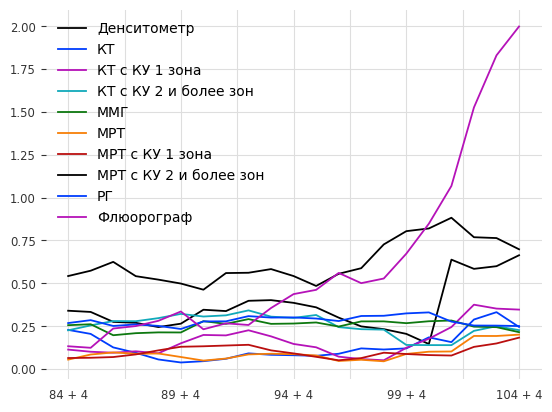

In [640]:
represent_cross_validation_results(models, ress).iloc[:-8, :].plot()

In [638]:
def represent_cross_validation_results(models, cross_val_results):

    for model in models:
        represent_model_dict = {}
        for validation_step in cross_val_results:
            represent_model_dict[validation_step] = cross_val_results[validation_step][model]


        represent_model_df = pd.DataFrame(represent_model_dict).T  # transpose DataFrame   
        model_df_with_stats = pd.concat([represent_model_df,  represent_model_df.describe()])
        
        display(model_df_with_stats.style.set_caption(f'{model}'))

    return model_df_with_stats



represent_cross_validation_results(models,ress)

,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.123962,0.522608,0.148842,0.050066,0.180985,0.181530,0.056057,0.477575,0.142713,0.244346
85 + 4,0.129042,0.416583,0.109022,0.061739,0.192264,0.193707,0.041751,0.374550,0.176284,0.243383
86 + 4,0.124578,0.280735,0.101551,0.085162,0.151446,0.185160,0.051537,0.372428,0.155438,0.349244
87 + 4,0.143368,0.205484,0.071531,0.120678,0.159848,0.163278,0.040952,0.302823,0.183311,0.359472
88 + 4,0.162163,0.146825,0.085784,0.158832,0.183027,0.143305,0.054577,0.261200,0.207429,0.365132
89 + 4,0.193345,0.092193,0.105216,0.211461,0.201831,0.116355,0.070880,0.369829,0.220400,0.380301
90 + 4,0.234426,0.067834,0.129813,0.231950,0.267473,0.111049,0.077184,0.353855,0.287881,0.263371
91 + 4,0.253454,0.039563,0.159691,0.266808,0.282356,0.120118,0.108417,0.430046,0.298408,0.262722
92 + 4,0.271908,0.028780,0.172230,0.282102,0.292526,0.125041,0.118907,0.521729,0.301264,0.259359
93 + 4,0.292095,0.029040,0.127446,0.262637,0.280470,0.134496,0.107280,0.553467,0.293296,0.298547


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.340149,0.228405,0.113406,0.225882,0.255791,0.054850,0.064273,0.542424,0.268210,0.132958
85 + 4,0.333061,0.204933,0.100873,0.254547,0.261242,0.084699,0.065749,0.573674,0.285237,0.123887
86 + 4,0.275116,0.126175,0.095266,0.279949,0.197236,0.096964,0.069949,0.625145,0.251292,0.236366
87 + 4,0.269600,0.094666,0.103460,0.278980,0.209205,0.088836,0.085248,0.541811,0.260254,0.250671
88 + 4,0.244786,0.055882,0.091745,0.296891,0.213853,0.090636,0.108863,0.521609,0.251670,0.281241
89 + 4,0.264619,0.038251,0.150206,0.321669,0.213366,0.070191,0.129921,0.498693,0.233569,0.335626
90 + 4,0.345944,0.045802,0.198828,0.306314,0.279212,0.049270,0.132733,0.462847,0.277737,0.231837
91 + 4,0.338121,0.059805,0.196224,0.313228,0.263660,0.061147,0.137154,0.559906,0.278329,0.266600
92 + 4,0.398070,0.091369,0.226086,0.342150,0.291288,0.085274,0.141377,0.561642,0.308613,0.256944
93 + 4,0.401951,0.083046,0.190613,0.305670,0.263541,0.089250,0.108845,0.583071,0.300278,0.356058


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.340149,0.228405,0.113406,0.225882,0.255791,0.054850,0.064273,0.542424,0.268210,0.132958
85 + 4,0.333061,0.204933,0.100873,0.254547,0.261242,0.084699,0.065749,0.573674,0.285237,0.123887
86 + 4,0.275116,0.126175,0.095266,0.279949,0.197236,0.096964,0.069949,0.625145,0.251292,0.236366
87 + 4,0.269600,0.094666,0.103460,0.278980,0.209205,0.088836,0.085248,0.541811,0.260254,0.250671
88 + 4,0.244786,0.055882,0.091745,0.296891,0.213853,0.090636,0.108863,0.521609,0.251670,0.281241
89 + 4,0.264619,0.038251,0.150206,0.321669,0.213366,0.070191,0.129921,0.498693,0.233569,0.335626
90 + 4,0.345944,0.045802,0.198828,0.306314,0.279212,0.049270,0.132733,0.462847,0.277737,0.231837
91 + 4,0.338121,0.059805,0.196224,0.313228,0.263660,0.061147,0.137154,0.559906,0.278329,0.266600
92 + 4,0.398070,0.091369,0.226086,0.342150,0.291288,0.085274,0.141377,0.561642,0.308613,0.256944
93 + 4,0.401951,0.083046,0.190613,0.305670,0.263541,0.089250,0.108845,0.583071,0.300278,0.356058


In [385]:
predictions.to_csv("../../data/processed/naive_models.csv", index=False)

### Varima модель

In [619]:
from darts.models.forecasting.varima import VARIMA

In [620]:
from darts.models.forecasting.catboost_model import CatBoostModel
from darts.models.forecasting.prophet_model import Prophet

In [650]:
models_alt = {
    'VARIMA': VARIMA(trend="ct"), 
    # "CatBoostModel": CatBoostModel(
    #     lags=[-1, -2, -3, -4, -5, -6, -12, -13, -52, -53, -51, -50, -54],
    #     # lags_future_covariates=[0],
    #     # output_chunk_length=10,
    # ),
}

In [651]:
alt_ress, alt_predictions = cross_val(models_alt, series)
represent_cross_validation_results(models_alt, alt_ress)

n_rows_to_train: 84 n_rows_for_forecast: 88


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 85 n_rows_for_forecast: 89


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 86 n_rows_for_forecast: 90


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 87 n_rows_for_forecast: 91


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 88 n_rows_for_forecast: 92


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 89 n_rows_for_forecast: 93


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 90 n_rows_for_forecast: 94


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 91 n_rows_for_forecast: 95


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 92 n_rows_for_forecast: 96


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 93 n_rows_for_forecast: 97


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 94 n_rows_for_forecast: 98


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 95 n_rows_for_forecast: 99


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 96 n_rows_for_forecast: 100


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 97 n_rows_for_forecast: 101


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 98 n_rows_for_forecast: 102


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 99 n_rows_for_forecast: 103


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 100 n_rows_for_forecast: 104


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 101 n_rows_for_forecast: 105


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 102 n_rows_for_forecast: 106


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 103 n_rows_for_forecast: 107


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_rows_to_train: 104 n_rows_for_forecast: 108


/tmp/ipykernel_433471/1786069584.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
/home/amecheryakov/miniconda3/envs/lct_hackathone/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.241678,0.120562,0.371089,0.167723,0.180770,0.141159,0.136421,0.438356,0.089301,0.268324
85 + 4,0.176068,0.156945,0.204779,0.116850,0.168471,0.174880,0.136456,0.335551,0.047296,0.308607
86 + 4,0.218501,0.157884,0.167429,0.037855,0.191425,0.077653,0.075214,0.294109,0.072404,0.280448
87 + 4,0.193333,0.157588,0.099332,0.057652,0.211622,0.075094,0.070204,0.203983,0.080540,0.319184
88 + 4,0.196290,0.232748,0.108222,0.063491,0.126989,0.103708,0.098911,0.225279,0.087741,0.320163
89 + 4,0.123849,0.294592,0.039838,0.186293,0.083186,0.082239,0.043626,0.420843,0.072759,0.305403
90 + 4,0.125663,0.151786,0.128114,0.123125,0.135198,0.144365,0.047516,0.238379,0.163778,0.100740
91 + 4,0.079792,0.209031,0.110152,0.216516,0.090057,0.214877,0.098465,0.346223,0.088199,0.041386
92 + 4,0.115398,0.299365,0.048790,0.150014,0.114179,0.156267,0.037813,0.513692,0.120682,0.083398
93 + 4,0.160616,0.203206,0.054576,0.125604,0.121958,0.179383,0.071563,0.479208,0.119852,0.245153


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.241678,0.120562,0.371089,0.167723,0.180770,0.141159,0.136421,0.438356,0.089301,0.268324
85 + 4,0.176068,0.156945,0.204779,0.116850,0.168471,0.174880,0.136456,0.335551,0.047296,0.308607
86 + 4,0.218501,0.157884,0.167429,0.037855,0.191425,0.077653,0.075214,0.294109,0.072404,0.280448
87 + 4,0.193333,0.157588,0.099332,0.057652,0.211622,0.075094,0.070204,0.203983,0.080540,0.319184
88 + 4,0.196290,0.232748,0.108222,0.063491,0.126989,0.103708,0.098911,0.225279,0.087741,0.320163
89 + 4,0.123849,0.294592,0.039838,0.186293,0.083186,0.082239,0.043626,0.420843,0.072759,0.305403
90 + 4,0.125663,0.151786,0.128114,0.123125,0.135198,0.144365,0.047516,0.238379,0.163778,0.100740
91 + 4,0.079792,0.209031,0.110152,0.216516,0.090057,0.214877,0.098465,0.346223,0.088199,0.041386
92 + 4,0.115398,0.299365,0.048790,0.150014,0.114179,0.156267,0.037813,0.513692,0.120682,0.083398
93 + 4,0.160616,0.203206,0.054576,0.125604,0.121958,0.179383,0.071563,0.479208,0.119852,0.245153


,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
84 + 4,0.241678,0.120562,0.371089,0.167723,0.180770,0.141159,0.136421,0.438356,0.089301,0.268324
85 + 4,0.176068,0.156945,0.204779,0.116850,0.168471,0.174880,0.136456,0.335551,0.047296,0.308607
86 + 4,0.218501,0.157884,0.167429,0.037855,0.191425,0.077653,0.075214,0.294109,0.072404,0.280448
87 + 4,0.193333,0.157588,0.099332,0.057652,0.211622,0.075094,0.070204,0.203983,0.080540,0.319184
88 + 4,0.196290,0.232748,0.108222,0.063491,0.126989,0.103708,0.098911,0.225279,0.087741,0.320163
89 + 4,0.123849,0.294592,0.039838,0.186293,0.083186,0.082239,0.043626,0.420843,0.072759,0.305403
90 + 4,0.125663,0.151786,0.128114,0.123125,0.135198,0.144365,0.047516,0.238379,0.163778,0.100740
91 + 4,0.079792,0.209031,0.110152,0.216516,0.090057,0.214877,0.098465,0.346223,0.088199,0.041386
92 + 4,0.115398,0.299365,0.048790,0.150014,0.114179,0.156267,0.037813,0.513692,0.120682,0.083398
93 + 4,0.160616,0.203206,0.054576,0.125604,0.121958,0.179383,0.071563,0.479208,0.119852,0.245153


<Axes: >

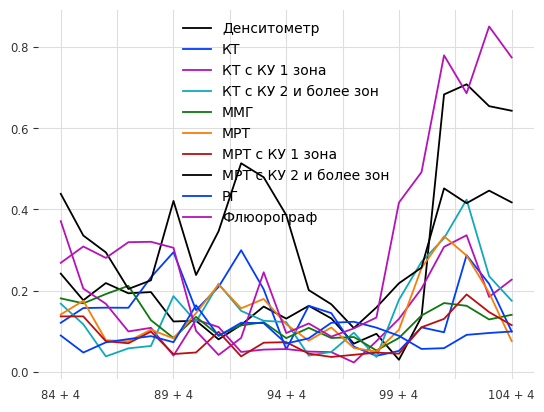

In [652]:
represent_cross_validation_results(models_alt, alt_ress).iloc[:-8, :].plot()

<Axes: xlabel='n_rows_to_train'>

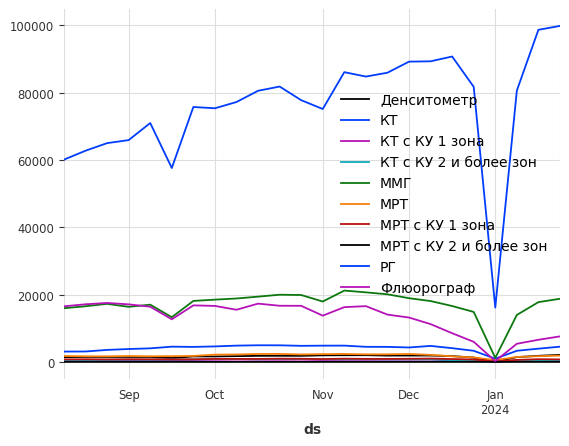

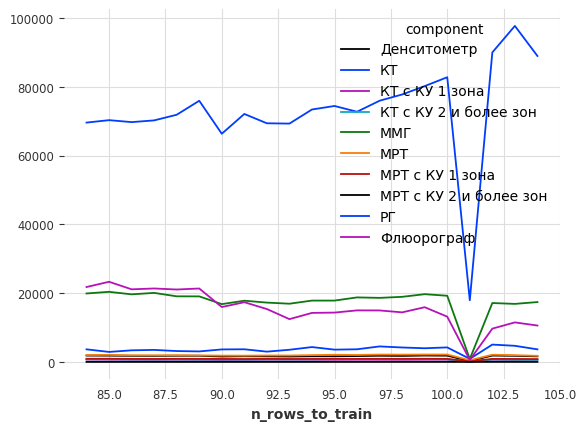

In [660]:
df_prophet[df_prophet["ds"] >= "2023-08-14"].set_index("ds").plot()
alt_predictions.groupby(["n_rows_to_train"]).last().drop(columns=["week_num_prediction"]).plot()


In [657]:
alt_predictions.to_csv("../../data/processed/varima_plus_naive_ct_trend.csv", index=False)

### FB prophet

In [476]:
from prophet import Prophet
from pandas.tseries.offsets import DateOffset

In [443]:
models_prophet = {
    'Prophet': Prophet(), 
}

In [637]:
def prophet_cross_val(
        series: TimeSeries,
        remains_rows_to_val: int = 24,
        n_rows_to_forecast: int = 4,
        step: int = 1,
) -> Dict[str, Dict[str, pd.Series]]:
    """
    Perform cross-validation on a given set of models and a time series.

    Args:
        models (Dict[str, object]): A dictionary of models to be used for cross-validation.
        series (TimeSeries): The time series data to be used for cross-validation.
        remains_rows_to_val (int, optional): The number of rows to be used for validation. Defaults to 24.
        n_rows_to_forecast (int, optional): The number of rows to be forecasted. Defaults to 4.
        step (int, optional): The step size for iterating over the training data. Defaults to 1.

    Returns:
        Dict[str, Dict[str, pd.Series]]: A dictionary containing the cross-validation results for each combination of training and forecasting
        rows. The keys are strings representing the combination of rows, and the values are dictionaries containing
        the MAPE (mean absolute percentage error) for each model by each column.
      Example: []
    """
    remains_rows_to_val = 24
    n_rows_to_forecast = 4
    step = 1
    if remains_rows_to_val < n_rows_to_forecast:
        raise ValueError("remains_rows_to_val count must be higher then n_rows_to_forecast")

    cross_val_results = {}
    # 109 - 24          85 + 4, 86 + 4, 87 + 4 ...........

    model_results = {}
    predicts_list = []
    for n_rows_to_train in range(len(series) - remains_rows_to_val, len(series) - n_rows_to_forecast + 1, step):
        print(f"n_rows_to_train: {n_rows_to_train}", f"i_rows_for_forecast: {n_rows_to_train + 1} - {n_rows_to_train + n_rows_to_forecast}")
        train = series[:n_rows_to_train]
        val = series[n_rows_to_train:n_rows_to_train + n_rows_to_forecast]

        iteration_results = {}
        features_column = set(train.columns) - {"ds"}
        
        # Adding holidays effect
        # df_holidays = series.loc[series["ds"].dt.strftime("%W").isin(["01"]), ["ds"]].copy()
        # df_holidays["holiday"] = "new_year"
        current_predictions = []
        for column in features_column:
            
            model = Prophet(yearly_seasonality=True)#.add_seasonality(period=3*30.4, name='quarterly', fourier_order=15) #Prophet(holidays=df_holidays)
            train_current = train[["ds", column]].rename(columns={column: "y"}).copy()

            # train_current["y"] = train_current["y"].diff()
            
            # Drop first week in train
            train_current_no_week = train_current.copy()
            train_current_no_week[train_current_no_week["ds"].dt.strftime("%W") == "01"] = None
            train_current_no_week = train_current_no_week.fillna(method="ffill")
            
            model.fit(train_current_no_week)
            df_future = model.make_future_dataframe(periods=4, freq="W-MON")
            preds = model.predict(df_future)
            

            df_shifted_values = series.copy()
            columns_to_shift = df_shifted_values.drop(columns=["ds"]).columns
            df_shifted_values[columns_to_shift] = df_shifted_values[columns_to_shift].shift(52)
            df_shifted_values.set_index("ds")
            preds.set_index("ds", inplace=True)
            df_shifted_values.set_index("ds", inplace=True)
            preds.loc[preds.index.strftime("%W") == "01", "yhat"] = df_shifted_values[column]
            
            # Add predictions to output
            df_pred = preds.reset_index().tail(n_rows_to_forecast)[["ds", "yhat"]].rename(columns={"yhat": column}).copy()
            if current_predictions == []:
                current_predictions.append(df_pred)
            else:
                current_predictions.append(df_pred[column])
            iteration_results[column] = mean_absolute_percentage_error(val[column].values, preds["yhat"].tail(n_rows_to_forecast).values) # .cumsum()
        
        df_current_pred = pd.concat(current_predictions, axis=1)
        df_current_pred['model_name'] = "fbprophet"
        df_current_pred['n_rows_to_train'] = n_rows_to_train
        df_current_pred['week_num_prediction'] = df_pred.index
        predicts_list.append(df_current_pred)
        model_results[f'{n_rows_to_train} + {n_rows_to_forecast}'] = pd.Series(iteration_results)

        cross_val_results["prophet"] = model_results
    return cross_val_results, pd.concat(predicts_list)

def represent_cross_validation_results_single(
    cross_val_results: Dict[str, Dict[str, pd.Series]]
) -> None:
    """
    Represent the cross-validation results for each model.

    Args:
        models (Dict[str, object]): A dictionary of models.
        cross_val_results (Dict[str, Dict[str, float]]): A dictionary containing the cross-validation results
            
    Returns:
        None
    """
    for model in cross_val_results:
        represent_model_dict = {}
        for validation_step in cross_val_results[model]:
            represent_model_dict[validation_step] = cross_val_results[model][validation_step]

        represent_model_df = pd.DataFrame(represent_model_dict).T  # transpose DataFrame
        model_df_with_stats = pd.concat([represent_model_df, represent_model_df.describe()])

        display(model_df_with_stats.style.set_caption(f'{model}'))

    return model_df_with_stats

In [577]:
df_prophet = df[["ds"] + [column for column in df.columns if column not in ['ds'] and 'feat' not in column]]

In [578]:
df_prophet

,ds,Денситометр,КТ,КТ с КУ 1 зона,КТ с КУ 2 и более зон,ММГ,МРТ,МРТ с КУ 1 зона,МРТ с КУ 2 и более зон,РГ,Флюорограф
1,2022-01-03,17.0,6146,43.0,100.0,483,415,169.0,2.0,12450,392.0
2,2022-01-10,1026.0,10868,424.0,451.0,9567,2156,669.0,9.0,48904,22626.0
3,2022-01-17,910.0,12266,430.0,490.0,8791,2162,710.0,14.0,47364,20496.0
4,2022-01-24,679.0,12793,336.0,471.0,7465,2066,667.0,7.0,40234,15227.0
5,2022-01-31,571.0,13235,302.0,446.0,6124,1900,609.0,6.0,36502,12586.0
...,...,...,...,...,...,...,...,...,...,...,...
104,2023-12-25,1294.0,3313,491.0,476.0,14856,1327,715.0,11.0,81751,5979.0
105,2024-01-01,84.0,950,70.0,73.0,1185,544,131.0,1.0,16148,241.0
106,2024-01-08,1427.0,3317,431.0,369.0,13964,1461,593.0,12.0,80644,5394.0
107,2024-01-15,1816.0,3939,563.0,518.0,17769,1712,809.0,17.0,98705,6580.0


In [589]:
prophet_ress, prophet_predictions = prophet_cross_val(df_prophet)
represent_cross_validation_results_single(prophet_ress)

/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:50 - cmdstanpy - INFO - Chain [1] start processing


n_rows_to_train: 84 i_rows_for_forecast: 85 - 88


18:23:50 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:50 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:51 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 85 i_rows_for_forecast: 86 - 89


18:23:53 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 86 i_rows_for_forecast: 87 - 90


18:23:57 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:57 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:23:57 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 87 i_rows_for_forecast: 88 - 91


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:01 - cmdstanpy - INFO - Cha

n_rows_to_train: 88 i_rows_for_forecast: 89 - 92


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:03 - cmdstanpy - INFO - Chain [1] start processing
18:24:04 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:04 - cmdstanpy - INFO - Chain [1] start processing
18:24:04 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:04 - cmdstanpy - INFO - Cha

n_rows_to_train: 89 i_rows_for_forecast: 90 - 93


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:08 - cmdstanpy - INFO - Cha

n_rows_to_train: 90 i_rows_for_forecast: 91 - 94


18:24:10 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 91 i_rows_for_forecast: 92 - 95


18:24:14 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 92 i_rows_for_forecast: 93 - 96


18:24:17 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:17 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 93 i_rows_for_forecast: 94 - 97


18:24:21 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 94 i_rows_for_forecast: 95 - 98


18:24:24 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:25 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 95 i_rows_for_forecast: 96 - 99


18:24:28 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:28 - cmdstanpy - INFO - Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:29 - cmdstanpy - INFO - Chain [1] start processing
18:24:29 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 96 i_rows_for_forecast: 97 - 100


18:24:32 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:32 - cmdstanpy - INFO - Chain [1] start processing
18:24:32 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:32 - cmdstanpy - INFO - Chain [1] start processing
18:24:32 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 97 i_rows_for_forecast: 98 - 101


18:24:36 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 98 i_rows_for_forecast: 99 - 102


18:24:39 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:39 - cmdstanpy - INFO - Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:40 - cmdstanpy - INFO - Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 99 i_rows_for_forecast: 100 - 103


18:24:43 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:44 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 100 i_rows_for_forecast: 101 - 104


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:48 - cmdstanpy - INFO - Cha

n_rows_to_train: 101 i_rows_for_forecast: 102 - 105


18:24:51 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:51 - cmdstanpy - INFO - Chain [1] start processing
18:24:51 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:51 - cmdstanpy - INFO - Chain [1] start processing
18:24:51 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

n_rows_to_train: 102 i_rows_for_forecast: 103 - 106


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:52 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:52 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:53 - cmdstanpy - INFO - Cha

n_rows_to_train: 103 i_rows_for_forecast: 104 - 107


/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:54 - cmdstanpy - INFO - Chain [1] start processing
18:24:54 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:54 - cmdstanpy - INFO - Chain [1] start processing
18:24:54 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:54 - cmdstanpy - INFO - Cha

n_rows_to_train: 104 i_rows_for_forecast: 105 - 108


18:24:55 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.fillna(method="ffill")
18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_433471/1725869738.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_current_no_week = train_current_no_week.

,Денситометр,МРТ,МРТ с КУ 2 и более зон,КТ с КУ 1 зона,КТ,ММГ,Флюорограф,МРТ с КУ 1 зона,КТ с КУ 2 и более зон,РГ
84 + 4,0.200278,0.123617,0.474811,0.430801,0.285901,0.106181,0.126761,0.158643,0.127512,0.064606
85 + 4,0.189402,0.131348,0.347727,0.366938,0.169967,0.089395,0.115240,0.137648,0.089074,0.034262
86 + 4,0.271195,0.117141,0.318201,0.348562,0.081862,0.159704,0.206352,0.144976,0.042723,0.057352
87 + 4,0.242837,0.090729,0.239520,0.292405,0.068119,0.149965,0.208937,0.128909,0.034074,0.086939
88 + 4,0.214643,0.102808,0.191053,0.222071,0.086209,0.118665,0.208604,0.098480,0.066727,0.104803
89 + 4,0.169469,0.109817,0.286910,0.132925,0.131264,0.101248,0.215920,0.074848,0.108980,0.119384
90 + 4,0.040343,0.140931,0.244114,0.062202,0.150925,0.022057,0.098019,0.044469,0.131082,0.139160
91 + 4,0.036229,0.186663,0.329310,0.033464,0.170645,0.039122,0.091417,0.044488,0.167160,0.140554
92 + 4,0.028582,0.186953,0.436591,0.046957,0.169340,0.051040,0.084112,0.054260,0.179386,0.129671
93 + 4,0.051674,0.191971,0.462057,0.053799,0.159506,0.055343,0.109666,0.052865,0.148187,0.108804


,Денситометр,МРТ,МРТ с КУ 2 и более зон,КТ с КУ 1 зона,КТ,ММГ,Флюорограф,МРТ с КУ 1 зона,КТ с КУ 2 и более зон,РГ
84 + 4,0.200278,0.123617,0.474811,0.430801,0.285901,0.106181,0.126761,0.158643,0.127512,0.064606
85 + 4,0.189402,0.131348,0.347727,0.366938,0.169967,0.089395,0.115240,0.137648,0.089074,0.034262
86 + 4,0.271195,0.117141,0.318201,0.348562,0.081862,0.159704,0.206352,0.144976,0.042723,0.057352
87 + 4,0.242837,0.090729,0.239520,0.292405,0.068119,0.149965,0.208937,0.128909,0.034074,0.086939
88 + 4,0.214643,0.102808,0.191053,0.222071,0.086209,0.118665,0.208604,0.098480,0.066727,0.104803
89 + 4,0.169469,0.109817,0.286910,0.132925,0.131264,0.101248,0.215920,0.074848,0.108980,0.119384
90 + 4,0.040343,0.140931,0.244114,0.062202,0.150925,0.022057,0.098019,0.044469,0.131082,0.139160
91 + 4,0.036229,0.186663,0.329310,0.033464,0.170645,0.039122,0.091417,0.044488,0.167160,0.140554
92 + 4,0.028582,0.186953,0.436591,0.046957,0.169340,0.051040,0.084112,0.054260,0.179386,0.129671
93 + 4,0.051674,0.191971,0.462057,0.053799,0.159506,0.055343,0.109666,0.052865,0.148187,0.108804


,Денситометр,МРТ,МРТ с КУ 2 и более зон,КТ с КУ 1 зона,КТ,ММГ,Флюорограф,МРТ с КУ 1 зона,КТ с КУ 2 и более зон,РГ
84 + 4,0.200278,0.123617,0.474811,0.430801,0.285901,0.106181,0.126761,0.158643,0.127512,0.064606
85 + 4,0.189402,0.131348,0.347727,0.366938,0.169967,0.089395,0.115240,0.137648,0.089074,0.034262
86 + 4,0.271195,0.117141,0.318201,0.348562,0.081862,0.159704,0.206352,0.144976,0.042723,0.057352
87 + 4,0.242837,0.090729,0.239520,0.292405,0.068119,0.149965,0.208937,0.128909,0.034074,0.086939
88 + 4,0.214643,0.102808,0.191053,0.222071,0.086209,0.118665,0.208604,0.098480,0.066727,0.104803
89 + 4,0.169469,0.109817,0.286910,0.132925,0.131264,0.101248,0.215920,0.074848,0.108980,0.119384
90 + 4,0.040343,0.140931,0.244114,0.062202,0.150925,0.022057,0.098019,0.044469,0.131082,0.139160
91 + 4,0.036229,0.186663,0.329310,0.033464,0.170645,0.039122,0.091417,0.044488,0.167160,0.140554
92 + 4,0.028582,0.186953,0.436591,0.046957,0.169340,0.051040,0.084112,0.054260,0.179386,0.129671
93 + 4,0.051674,0.191971,0.462057,0.053799,0.159506,0.055343,0.109666,0.052865,0.148187,0.108804


<Axes: >

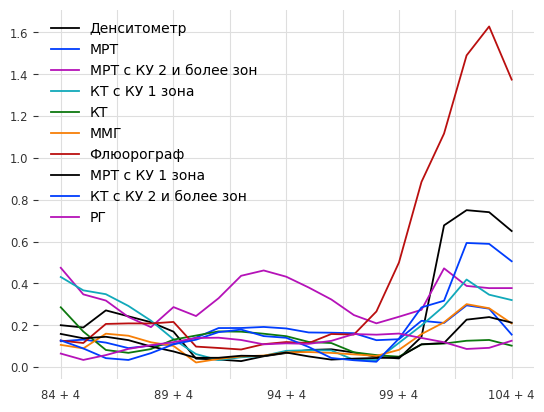

In [590]:
represent_cross_validation_results_single(prophet_ress).iloc[:-8, :].plot()

In [566]:
prophet_predictions.to_csv("../../data/processed/prophet_yearly_no_outliers.csv", index=False)

<Axes: xlabel='ds'>

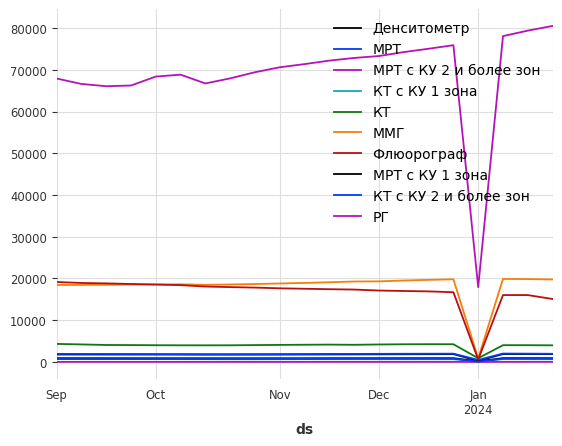

In [591]:
prophet_predictions.groupby(["n_rows_to_train"]).last().set_index("ds").drop(columns=[ "week_num_prediction"]).plot()

<Axes: xlabel='ds'>

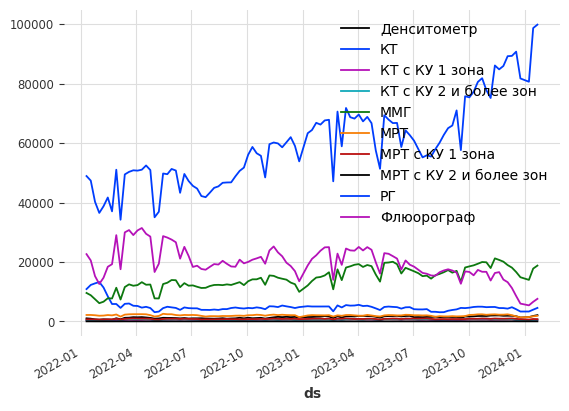

In [551]:
df_prophet[df_prophet["ds"].dt.strftime("%W") != "01"].set_index("ds").plot()

In [128]:
df_prophet["ds"].dt.strftime("%V")

1      01
2      02
3      03
4      04
5      05
       ..
104    52
105    01
106    02
107    03
108    04
Name: ds, Length: 108, dtype: object